# Betaseries for BBx


## Table of Conents:

* [FSL feat1 analysis](#feat1)  
* [Concatenate with fslmerge](#fslmerge)
* [Transform functionals with flirt and fslmath](#transform)
* [Pull Timeseries](#pull_timeseries)
* [Functional Connectivtiy Matrix plots](#fcm)


In [1]:
import glob
import os
import pandas as pd
from os import listdir
from shutil import rmtree
from subprocess import check_output
import argparse
import subprocess
from multiprocessing import Pool


In [2]:
# set variable paths 

ses_id='ses-1'
beta_path= '/projects/niblab/experiments/bbx/data/betaseries' 
study_path='/projects/niblab/experiments/bbx'
input_dir = '/projects/niblab/experiments/bbx/data'    
deriv_dir= os.path.join(input_dir, 'preprocessed')
design_file='/projects/niblab/experiments/bbx/data/code/beta_design.fsf'
ev_path='/projects/niblab/experiments/bbx/data/onsets/trials'
preprocess_folder= os.path.join(input_dir, 'preprocessed')


subject_folders=sorted(glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/sub-*'))
# get subject ids
subject_ids=[x.split('/')[-2] for x in glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-1')]






In [3]:

def chunks(l,n):
    return [l[i:i+n] for i in range(0, len(l), n)]

def run_multiprocess(chunks, function, poolsize=2):
    with Pool(poolsize) as p:
        return_data=p.map(function, chunks)
    return return_data

## Setup Feat files <a class='anchor' id='feat1'></a>

In [121]:
### Helper Functions 


# feat1 fsf file creation 
def make_file(sub_id, ses_id, trial_id, output_dir, task,data_dict, design_file, newkey, run):
    
    with open(design_file,'r') as infile:
        tempfsf=infile.read()
        #
        if not os.path.exists(os.path.join(output_dir, "design_files")):
            os.makedirs(os.path.join(output_dir, "design_files"))
        #print(output_dir)
        
        
        task_name=trial_id.replace(sub_id+'_',"")
        design_fileout = os.path.join(output_dir, "design_files/%s_%s_%s_beta1.fsf"%(sub_id, ses_id, task_name))
        out_param = data_dict[sub_id][newkey]["TRIALS"]["TRIAL%s"%trial_id]["OUTPUT"]
        func_param = data_dict[sub_id][newkey]["FUNCRUN"]
        confound_param = data_dict[sub_id][newkey]["CONFOUND"]
        trial_param = data_dict[sub_id][newkey]["TRIALS"]["TRIAL%s"%trial_id]["TRIAL"]
        nuis_param = data_dict[sub_id][newkey]["TRIALS"]["TRIAL%s"%trial_id]["NUIS"]
        #print(design_fileout)
        tempfsf = tempfsf.replace("OUTPUT", out_param)
        tempfsf = tempfsf.replace("FUNCRUN", func_param) 
        tempfsf = tempfsf.replace("CONFOUND", confound_param)
        tempfsf = tempfsf.replace("TRIAL", trial_param)
        tempfsf = tempfsf.replace("NUIS", nuis_param)

        for i in range(6):
            moco = data_dict[sub_id][newkey]["MOCO%i"%i]
            tempfsf = tempfsf.replace("MOCO%i"%i, moco)
        #print(tempfsf)
        try:
            with open(design_fileout,'w') as outfile:
                outfile.write(tempfsf)
            outfile.close()
        except:
            print("BAD SUBJECT ", sub_id)
        infile.close()
        
        
def create_fsf(input_dir, deriv_dir, ses_id, design_file, ev_path):
    
    ses_id=ses_id
    preproc_folder = deriv_dir
    
    data_dict={}
    
    
    # start loop -- looping through subjects
    subject_list = glob.glob(os.path.join(preproc_folder, 'sub-*/%s'%ses_id))
    for sub_path in subject_list:
        # set variables from file path
        sub_id=sub_path.split("/")[-2]
        # add subject id to dictionary
        if sub_id not in data_dict:
            data_dict[sub_id] = {}
            
            
            
        # get functional task files 
        # this section may be unique to an individual study,
        # make sure the extraction applies correctly. 
        
        # get list of nifti functional files of current subject
        # we use the `_preproc_bold_brain.nii.gz task files, these are preprocessed niftis
        functional_tasks = glob.glob(os.path.join(sub_path, 'func/*preproc_bold_brain.nii.gz'))
                
        
        for functional in functional_tasks: 
            # set specific variables from filename
            task=functional.split("/")[-1].split("_")[2].split("-")[1]
            if 'resting' in task:
                run=""
                pass
            else:
                run=functional.split("/")[-1].split("_")[3]

                
                #print(task,run)

                analysis_folder=os.path.join(deriv_dir, '%s/%s'%(sub_id,ses_id), "analysis")
                #print(analysis_folder)
                output_dir = os.path.join(analysis_folder, 'beta/task-%s_%s'%(task,run))
                #print('[INFO] output directory: ', output_dir)
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                # set confound file
                #sub-001_ses-1_task-training_run-1_space-MNI152NLin2009cAsym_desc-preproc_confound.txt

                if 'resting' in task:
                    confound_file = os.path.join(sub_path, "func/motion_assessment/%s_%s_task-%s_space-MNI152NLin2009cAsym_desc-preproc_confound.txt"%(sub_id,ses_id, task))
                else:
                    confound_file = os.path.join(sub_path, "func/motion_assessment/%s_%s_task-%s_%s_space-MNI152NLin2009cAsym_desc-preproc_confound.txt"%(sub_id,ses_id, task, run))

                #print(confound_file)
                #print(run)
                if 'run' in run:
                    newkey="%s_%s"%(task, run)
                else:
                    newkey="%s"%task
                #print(newkey)
                data_dict[sub_id][newkey] = {
                    "TRIALS" : { },
                    "CONFOUND" : confound_file,
                    "FUNCRUN" : functional
                  }           

                # set motion parameters
                # sub-001_ses-1_task-training_run-1_moco0.txt | sub-001_ses-1_task-resting_moco5.txt
                for i in range(6):
                    if 'run' in run:
                        motcor=os.path.join(sub_path, 'func','motion_assessment', 'motion_parameters','%s_%s_task-%s_%s_moco%s.txt'%(sub_id,ses_id, task,run,i))
                    else:
                        motcor=os.path.join(sub_path, 'func','motion_assessment', 'motion_parameters','%s_%s_task-%s_moco%s.txt'%(sub_id,ses_id, task,i))
                    #print(motcor)
                    data_dict[sub_id][newkey]['MOCO%i'%i] = motcor

                #print(data_dict)

                # setup evs(onsets)
                trial_evs = sorted(glob.glob(os.path.join(ev_path, '%s_*%s*.txt'%(sub_id, run))))
                #print(trial_evs[0])

                if not trial_evs:
                    pass
                else:
                    for trial_file in trial_evs:
                        _id = sub_id.split("-")[1]
                        _id = _id[1:]
                        trial_id = trial_file.split("/")[-1].split(".")[0]
                        #print(trial_id)
                        nuis_file = os.path.join(ev_path, '%s.txt'%trial_id.replace('trial', 'nuis'))
                        #print(nuis_file)
                        
                        trial_ext=trial_id.replace(sub_id+'_',"")
                        fileout = os.path.join(output_dir, "%s_%s_%s"%(sub_id, ses_id,trial_ext))
                        #print(fileout)
                        
                        # fill dictionary
                        data_dict[sub_id][newkey]["TRIALS"]["TRIAL%s"%trial_id] = {"TRIAL" : trial_file, "NUIS": nuis_file, "OUTPUT" : fileout}
                        
                        # write out file
                        make_file(sub_id, ses_id, trial_id,output_dir, task, data_dict,design_file, newkey, run)

                
    return(data_dict) 
        

In [123]:
# make feat1 fsf files
print('[INFO] making fsf design files...')
#data_dict=create_fsf(input_dir, deriv_dir,ses_id,design_file,ev_path)
print('[INFO] process complete.')


[INFO] making fsf design files...
[INFO] process complete.


Lets view a few of files created

In [4]:
# look at created files
output_path='/projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/analysis/beta/task-training_run-4/design_files'
listdir(output_path)[:5]
        

['sub-001_ses-1_task-H2O-run-4_trial1_beta1.fsf',
 'sub-001_ses-1_task-H2O-run-4_trial2_beta1.fsf',
 'sub-001_ses-1_task-H2O-run-4_trial3_beta1.fsf',
 'sub-001_ses-1_task-H2O-run-4_trial4_beta1.fsf',
 'sub-001_ses-1_task-H2O-run-4_trial5_beta1.fsf']

In [5]:
beta1_files_path='/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-1/analysis/beta/task-training_run-*/design_files/*.fsf'
print('[INFO] %f fsf files available.'%len(glob.glob(beta1_files_path)))


[INFO] 32392.000000 fsf files available.


In [6]:
# view a few of the files
glob.glob(beta1_files_path)[:5]

['/projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/analysis/beta/task-training_run-4/design_files/sub-001_ses-1_task-H2O-run-4_trial1_beta1.fsf',
 '/projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/analysis/beta/task-training_run-4/design_files/sub-001_ses-1_task-H2O-run-4_trial2_beta1.fsf',
 '/projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/analysis/beta/task-training_run-4/design_files/sub-001_ses-1_task-H2O-run-4_trial3_beta1.fsf',
 '/projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/analysis/beta/task-training_run-4/design_files/sub-001_ses-1_task-H2O-run-4_trial4_beta1.fsf',
 '/projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/analysis/beta/task-training_run-4/design_files/sub-001_ses-1_task-H2O-run-4_trial5_beta1.fsf']

## Submit slurm jobs

Tasks Available

In [7]:
len(subject_ids)

129

In [8]:
tasks=[x.split("/")[-1].split("_")[2].split("-")[1] for x in glob.glob(output_path+"/*.fsf")]
set(tasks)


{'H2O', 'H2Ocue', 'SSB', 'SSBcue', 'USB', 'USBcue', 'rinse'}

In [127]:
def by_file_slurm(subject,ev_task):
    fsf_path='/projects/niblab/experiments/bbx/data/preprocessed/{}/ses-1/analysis/beta/task-training_run-*/design_files/*{}*.fsf'.format(subject, ev_task)
    fsfs=glob.glob(fsf_path)
    for fsf in fsfs:
        slurm_cmd = "sbatch /projects/niblab/experiments/bbx/data/code/beta_by_file.job {}".format(fsf)
        #print('[INFO] submitted: \n', slurm_cmd)
        os.system(slurm_cmd)
    


In [129]:
# run all jobs
print('[INFO] setting up batch jobs.')
ev_task='USB'
for subject in subject_ids[60:]:    
    by_file_slurm(subject, ev_task)
    
print('[INFO] submitted batch jobs.')

    

[INFO] setting up batch jobs.
[INFO] submitted batch jobs.


In [18]:
#!squeue -u nbytes

**Setup Data Dictionary**

In [47]:
bad_subjects=[]
data_dict={}

for folder in subject_folders:
    subject_id=folder.split("/")[-1]
    tasks=glob.glob(os.path.join(folder,'ses-1/analysis/beta/*'))
    #print('[INFO] tasks: ', tasks)
    
    if not tasks:
        bad_subjects.append(subject_id)
    else:
        if subject_id not in data_dict:
            data_dict[subject_id]={}
        for task_folder in tasks:
            #print(task_folder)
            task=task_folder.split("/")[-1].split('.')[0]
            #print('[INFO] task: ', task)
            if task not in data_dict[subject_id]:
                data_dict[subject_id][task]={}
            pes=glob.glob(os.path.join(task_folder, '*.feat/stats/pe1.nii.gz'))
            data_dict[subject_id][task]=pes
       
    
    

In [ ]:
#data_dict['sub-001']['task-training_run-1']

## Concatenate PEs <a class="anchor" id="fslmerge"></a>

In [73]:
keyword="SSBcue"
bad_subjects=[]

In [74]:

def merge_files(subject_list, data_dict=data_dict,keyword=keyword):

    for subject_id in subject_list:
        for task in data_dict[subject_id]:
            #print('[INFO] task: ', task)
            pes=[pe for pe in data_dict[subject_id][task] if keyword in pe]
            if "-" in keyword:
                keyword=keyword.strip('-')
                
            #print("[INFO] PEs: ",pes)
            filename="%s_%s_%s"%(subject_id, task, keyword)
            outfile = "/projects/niblab/experiments/bbx/data/betaseries/niftis/%s/%s"%(keyword, filename)
            #print('[INFO] outfile: \n',outfile)
            if not os.path.exists("/projects/niblab/experiments/bbx/data/betaseries/niftis/%s"%keyword):
                 os.makedirs("/projects/niblab/experiments/bbx/data/betaseries/niftis/%s"%keyword)
                    
            if not pes:
                bad_subjects.append(subject_id)
            else:
                pe_str = " ".join(pes)
                fslmerge_cmd="/projects/niblab/modules/software/fsl/5.0.10/bin/fslmerge -t %s %s"%(outfile, pe_str)
                #print("[INFO] running fsl merge command...")
                #print(fslmerge_cmd, "\n")
                os.system(fslmerge_cmd)


            

In [75]:
chunksize=10
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(subject_ids, chunksize)

#print(chunk_list)
print("[INFO] running fslmerge ....\nfslmerge -t [OUTPUT FILENAME][PE FILES]")

with Pool(8) as p:
    p.map(merge_files, chunk_list)
print("[INFO] process complete.")
#print('[INFO] find images here: ',concat_path )

[INFO] chunksize: 10
[INFO] running fslmerge ....
fslmerge -t [OUTPUT FILENAME][PE FILES]
[INFO] process complete.


In [77]:
# Check for output timeseries files
print("[INFO] File counts \nUSB : {} \nUSBcue: {} \nSSB: {} \nSSBcue: {}".format(
    len(listdir(os.path.join(beta_path,'niftis/USB'))),
    len(listdir(os.path.join(beta_path,'niftis/USBcue'))),
    len(listdir(os.path.join(beta_path,'niftis/SSB'))),
    len(listdir(os.path.join(beta_path,'niftis/SSBcue')))))



[INFO] File counts 
USB : 507 
USBcue: 507 
SSB: 507 
SSBcue: 507


In [78]:
def tranform_niftis(niftis, keyword=keyword):
    reference_nifti='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.nii.gz'
    reference_mat='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.mat'
    for nii in niftis:

        # setup and run flirt
        nii=nii.replace('.nii.gz', '')
        out=nii#+'_3mm'
        flirt_cmd="flirt -in {} -ref {} -init {} -applyxfm -out {}".format(nii, reference_nifti, reference_mat, out)
        #print('[INFO] flirt command: \n{}'.format(flirt_cmd))
        os.system(flirt_cmd)

        fslmaths_cmd='fslmaths {} -thr 0.9 {}'.format(out,out)
        #print('[INFO] fslmaths command: \n{}'.format(fslmaths_cmd))
        os.system(fslmaths_cmd)

In [79]:

print('[INFO] transform functionals to match the mask.')
chunksize=10
# grab concatenated (fslmerge) data
keyword="SSBcue"
fslmerged_files=glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/betaseries/niftis/%s/*.nii.gz'%(keyword)))
#fslmerged_files[:4]
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(fslmerged_files, chunksize)
with Pool(8) as p:
    p.map(tranform_niftis, chunk_list)
print('[INFO] transformation process complete.')


[INFO] transform functionals to match the mask.
[INFO] chunksize: 10
[INFO] transformation process complete.


In [80]:
# Check for output timeseries files
print("[INFO] File counts \nUSB : {} \nUSBcue: {} \nSSB: {} \nSSBcue: {}".format(
    len(listdir(os.path.join(beta_path,'niftis/USB'))),
    len(listdir(os.path.join(beta_path,'niftis/USBcue'))),
    len(listdir(os.path.join(beta_path,'niftis/SSB'))),
    len(listdir(os.path.join(beta_path,'niftis/SSBcue')))))



[INFO] File counts 
USB : 507 
USBcue: 507 
SSB: 507 
SSBcue: 507


## Pull ROI timeseries  <a class="anchor" id="pull_timeseries"></a>


In [81]:
!sbatch /projects/niblab/experiments/bbx/data/betaseries/timeseries_roi_pull.job SSBcue



Submitted batch job 3285586


In [82]:
!squeue -j 3285586

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3285586     batch timeseri   nbytes PD       0:00      1 (Priority)


In [30]:
!squeue -j 3284761

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3284761     batch timeseri   nbytes  R       0:33      1 largemem-0-0


In [31]:
!squeue -j 3284762

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3284762     batch timeseri   nbytes  R       0:15      1 largemem-1-0


In [9]:
!squeue -u nbytes

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [30]:
# Check for output timeseries files
print("USB: {} \nUSBcue: {} \nSSB: {} \nSSBcue: {}".format(
    len(listdir(os.path.join(beta_path,'rois/bigbrain300/USB'))),
    len(listdir(os.path.join(beta_path,'rois/bigbrain300/USBcue'))),
    len(listdir(os.path.join(beta_path,'rois/bigbrain300/SSB'))),
    len(listdir(os.path.join(beta_path,'rois/bigbrain300/SSB')))))



USB: 152100 
USBcue: 152100 
SSB: 152100 
SSBcue: 152100


## Combine Timeseries into Matrix  <a class="anchor" id="combine_timeseries"></a>
Combine timeseries roi files into a large matrix, **one file per condition per participant**  

### Combine Timeseries into a Matrix, per subject by condition

In [43]:

def timeseries_concat(subject_ids,verbose=False):
    
    for subject_id in subject_ids:
        tasks=list(data_dict[subject_id].keys())
        for task in tasks:

            #print(subject_id, task, stim)
            #print(os.path.join(beta_path, 'rois/big300/%s'%stim))
            # get roi texts for subject / condition
            roi_files = glob.glob(os.path.join(beta_path, 'rois/bigbrain300/%s/%s*%s*.txt'%(stim, subject_id,task)))

            df_lst=[]
            #print(roi_files)
            try:
                for txt in roi_files: 
                    #print(txt)
                    df_temp = pd.read_csv(txt, sep="\n", header=None)
                    #print(df_temp)
                    df_lst.append(df_temp)
                #print(subject_id, task, len(df_lst))

                df_concat= pd.concat(df_lst, axis=1, sort=False)
                #print(df_concat)

                # write output file 
                
                if not os.path.exists(os.path.join(beta_path,'subject_matrices/%s'%stim)):
                    if verbose==True:
                        print('[INFO] making ',os.path.join(beta_path,'subject_matrices/%s'%stim))

                    os.makedirs(os.path.join(beta_path,'subject_matrices/%s'%stim))
                outfile=os.path.join(beta_path,
                                     'subject_matrices/%s/%s_%s_%s.txt'%(stim,subject_id,task, stim))
                if verbose==True:
                    print('[PROCESSING] making file %s....'%outfile)

                df_concat.to_csv(outfile, header=None, index=None, sep='\t')
            except:
                pass
                error_subjects.append((subject_id,task))

    #if error_subjects: print(error_subjects)
    return error_subjects;


    
    

In [62]:


def combine_timeseries(chunk_list, pool_size,stim):
    print("[INFO] combining trial condition into one timeseries matrix for stimulus %s...."%stim)
    print("[INFO] starting multiprocess....")
    
    with Pool(pool_size) as p:
        error_subjects=p.map(timeseries_concat, chunk_list)
        
        
        
        
stims=['SSBcue', 'USB', 'USBcue']
stim='SSB'
subject_ids=list(data_dict.keys())
error_subjects=[]
chunksize=15
pool_size=10
multi_stim = True

chunk_list=chunks(subject_ids, chunksize) 



print("[INFO] BUILDING TIMESERIES MATRIX, FOR EACH SUBJECT PER CONDITION")
print("[INFO] chunksize: {}".format(chunksize))
print("[INFO] poolsize: {}".format(chunksize))


     
# case for multiple stimulus       
if multi_stim == True:
    for stim in stims:
        combine_timeseries(chunk_list,pool_size,stim)
        print("[INFO] completed process.")
        
        
# case for running process on single stim
else:
    combine_timeseries(chunk_list,pool_size,stim)
    

    print("[INFO] completed process.")
    
    
    
#print("[INFO] process complete. \n[INFO] bad subjects: \t\t%s"%error_subjects)



[INFO] BUILDING TIMESERIES MATRIX, FOR EACH SUBJECT PER CONDITION
[INFO] chunksize: 15
[INFO] poolsize: 15
[INFO] combining trial condition into one timeseries matrix for stimulus SSBcue....
[INFO] starting multiprocess....
[INFO] completed process.
[INFO] combining trial condition into one timeseries matrix for stimulus USB....
[INFO] starting multiprocess....
[INFO] completed process.
[INFO] combining trial condition into one timeseries matrix for stimulus USBcue....
[INFO] starting multiprocess....
[INFO] completed process.


In [83]:
# view number of subject timeseries rois created/pulled
for stim in listdir(os.path.join(beta_path, 'subject_matrices')):
    print("[INFO] %s (%s files)"%(stim, 
                                  len(glob.glob(os.path.join(beta_path, 'subject_matrices/%s/*.txt'%stim)))))


[INFO] SSB (507 files)
[INFO] SSBcue (104 files)
[INFO] USB (507 files)
[INFO] USBcue (507 files)


In [ ]:
# Make FCM 

In [84]:
import seaborn as sns
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from matplotlib import pyplot as plt
from nilearn import plotting
from nilearn.plotting import plot_connectome


## Make Functional Connectivity Matrices <a class="anchor" id="fcm"></a>

In [88]:
# make fc matrices

"""
  Takes timeseries matrices and makes functional connectivity matrices with nilearns ConnectivityMeasure object.
  We pass a condition, or named here the 'file_suffix', to identify our individual task files,
  and we pass the number of extracted regions.
  Outputs: makes subject FCMs, plots FCMs
  Returns: a function correlation dictionary as well as individual subject list

  ** Extensions: plotting, save individual FCMs...
"""
def makeFCM(cmap, timeseries, stim, n_regions_extracted=300, functionals=None):
    #print('[INFO] making functional connectivity matrices with nilearn ConnectivityMeasure object...')
    fc_corr_dict = {}
    
    subj_list=[]
    bad_subjects=[]
    correlations = []
    # Initializing ConnectivityMeasure object with kind='correlation'
    connectome_measure = ConnectivityMeasure(kind='correlation')
    #print(timeseries)
    #print('[INFO] stim: ', stim)
    for subj_timeseries in sorted(timeseries):
        #print(subj_timeseries)
        subj_id=subj_timeseries.split("/")[-1].split("_")[0]
        if subj_id not in fc_corr_dict:
            fc_corr_dict[subj_id] = {}
        if subj_id not in subj_list:
            subj_list.append(subj_id)
        if stim in subj_timeseries:
            filename = "%s_task-%s.txt"%(subj_id, stim)
            try:
                # we load the text file timeseries into an array 
                np_arr = np.loadtxt(subj_timeseries)
                #print(np_arr)

                # call fit_transform from ConnectivityMeasure object
                correlation = connectome_measure.fit_transform([np_arr])
                #print('[INFO] CORRELATION: ', correlation)
                
                # saving each subject correlation to correlations
                fc_corr_dict[subj_id][stim] = correlation
                correlations.append(correlation)
                
                # plot subject correlation matrix
                #sns.heatmap(correlation, annot=True)
                # save text
                #np.savetxt('/content/'+filename, correlation.transpose(2,0,1).reshape(3,-1))
            except:
                bad_subjects.append(subj_id)
                pass
    try:
        # Mean of all correlations
        mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted, n_regions_extracted)



        ## plotting
        #print('[INFO] Plot of the mean functional connectivity matrix: \n')
        title = 'Correlation between %d regions, condition %s'%(n_regions_extracted,stim)
        # First plot the matrix
        print('[INFO] %s'%title)
        display = plotting.plot_matrix( mean_correlations,figure=(9, 7),
                                       colorbar=True, cmap=cmap) #, tri='lower')
        plt.show()
        print("\n")
        if bad_subjects:
            print('[INFO] bad subjects for %s....\t%s'%(stim,bad_subjects))

        # Then find the center of the regions and plot a connectome
        #regions_img = regions_extracted_img
        #coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

        #plotting.plot_connectome(mean_correlations, coords_connectome,
                              #edge_threshold='90%', title=title)"""

        #return fc_corr_dict, subj_list;
    except:
        pass



  

[INFO] making functional connectivity matrices (FCM)...
[INFO] Correlation between 300 regions, condition SSB


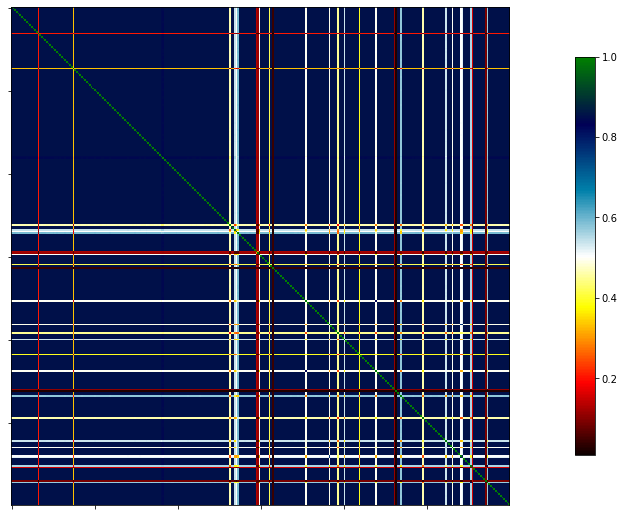



[INFO] Correlation between 300 regions, condition SSBcue


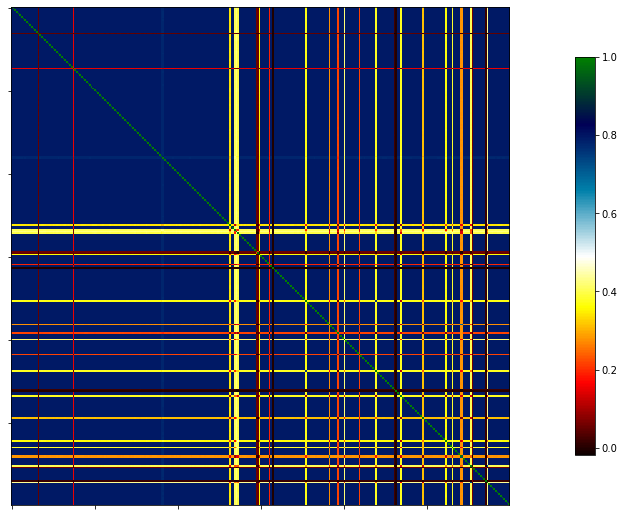



[INFO] Correlation between 300 regions, condition USB


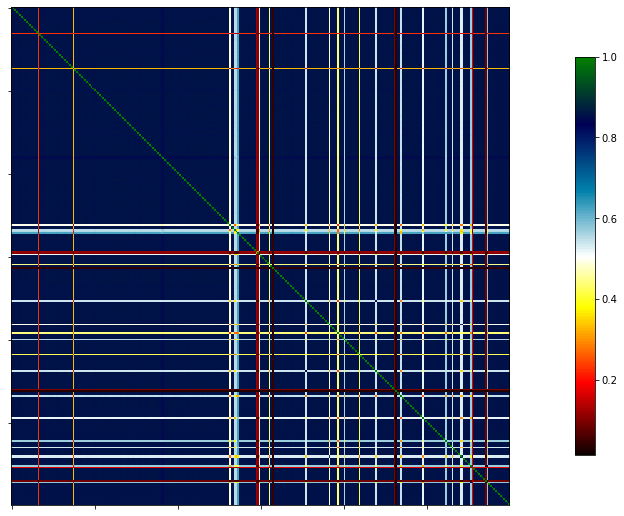

In [99]:
cmap="ocean_hot_r"#"BuPu"
stim_list=listdir(os.path.join(beta_path,'subject_matrices'))

print("[INFO] making functional connectivity matrices (FCM)...")
for stim in stim_list:
    timeseries_files=glob.glob(os.path.join(beta_path,'subject_matrices/%s/*.txt'%stim))
    #print(len(timeseries_files))
    if stim == "USBcue":
        pass
    else:
        makeFCM(cmap, timeseries_files, stim)
    
    